In [23]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import uproot
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from HyPER.models import MPNNs, HyperedgeModel, HyperedgeLoss, EdgeLoss, CombinedLoss
from torchmetrics.classification import BinaryAccuracy
import seaborn as sns
import joblib
import os
# os.makedirs("twz_results", exist_ok=True)
os.makedirs("twz_results_feb16", exist_ok=True)



In [24]:

# Configuration
jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Electron.T', 'Muon.PT', 'Muon.Eta', 'Muon.Phi', 'Muon.T']
# Muon_features = 
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

# signal_file = '/home/sandeep/Desktop/Windows files/project rootfiles/13TeV_signal_5k.root'
# # background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG_5k.root'
# background_file = '/home/sandeep/Desktop/Windows files/project rootfiles/13TeV_BKG_5k.root'
signal_file = "/home/sandeep/MG/twz/Events/run_06_decayed_1/tag_1_delphes_events.root"
# background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG_5k.root'
background_file = '/home/sandeep/MG/ttz/Events/run_03_decayed_1/tag_1_delphes_events.root'

tree_name = 'Delphes'
batch_size = 1028
delta_r_threshold = 2


In [25]:

# Helper functions
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)
    # return x

def convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_thresh=2.0):
    N = x_all.shape[0]
    if N == 0:
        return None

    edge_index_list = []
    edge_attr_list = []
    edge_target_list = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            edge_index_list.append([i, j])
            edge_attr_list.append([dr])
            edge_target_list.append([1 if dr < delta_r_thresh else 0])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).T
    edge_attr_s = torch.tensor(edge_attr_list, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target_list, dtype=torch.float)

    hyperedge_list = []
    for j in range(N):
        neighbors = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_thresh:
                neighbors.append(k)
        if len(neighbors) > 1:
            hyperedge_list.append(neighbors)

    if not hyperedge_list:
        return None

    node_indices = np.concatenate(hyperedge_list).astype(np.int64)
    hyperedge_indices = np.repeat(np.arange(len(hyperedge_list)), [len(h) for h in hyperedge_list]).astype(np.int64)
    hyperedge_index = torch.from_numpy(np.stack([node_indices, hyperedge_indices])).long()

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    data = Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        u_s=u_s,
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t.view(-1, 1),
        edge_index_h=hyperedge_index,
        edge_index_h_batch=torch.zeros(hyperedge_index.shape[1], dtype=torch.long),
        x_t=torch.tensor([label], dtype=torch.float),
        batch=torch.zeros(N, dtype=torch.long)
    )
    return data


In [26]:

def load_data_hyper_format(file_path, label):
    file = uproot.open(file_path)
    tree = file[tree_name]
    events = tree.arrays(all_features, library='np')
    data_list = []

    num_events = len(events[jet_features[0]])
    for i in range(num_events):
        jet_data = [events[feat][i] for feat in jet_features]
        x_jets = np.column_stack(jet_data)
        x_jets = np.nan_to_num(x_jets)
        x_jets = normalize_features(x_jets)

        elec_data = [events[feat][i] for feat in lepton_features[:4]]
        muon_data = [events[feat][i] for feat in lepton_features[4:]]
        x_elec = np.column_stack(elec_data) if len(elec_data[0]) > 0 else np.empty((0, 4))
        x_muon = np.column_stack(muon_data) if len(muon_data[0]) > 0 else np.empty((0, 4))
        x_leptons = np.vstack([x_elec, x_muon])

        if x_leptons.size == 0:
            x_leptons = np.zeros((0, 13))
        elif x_leptons.shape[1] != 13:
            x_leptons = np.pad(x_leptons, ((0, 0), (0, 13 - x_leptons.shape[1])), mode='constant')
        x_leptons = normalize_features(x_leptons)

        met_data = [events[feat][i] for feat in met_features]
        x_met = np.array(met_data).reshape(1, -1)
        x_met = np.nan_to_num(x_met)
        if x_met.shape[1] != 13:
            x_met = np.pad(x_met, ((0, 0), (0, 13 - x_met.shape[1])), mode='constant')
        x_met = normalize_features(x_met)

        x_all = np.vstack([x_jets, x_leptons, x_met])
        eta_all = np.concatenate([
            x_jets[:, 5] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 1] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 1] if x_met.shape[0] > 0 else np.array([])
        ])
        phi_all = np.concatenate([
            x_jets[:, 1] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 2] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 0] if x_met.shape[0] > 0 else np.array([])
        ])

        data = convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_threshold)
        if data:
            data_list.append(data)

    return data_list


In [27]:
# Load full dataset
signal_data = load_data_hyper_format(signal_file, 1)
background_data = load_data_hyper_format(background_file, 0)
dataset = signal_data + background_data
np.random.shuffle(dataset)
split = int(0.7 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# TensorBoard logger
logger = TensorBoardLogger("lightning_logs", name="hypergraph")


In [28]:
from pytorch_lightning.callbacks import ModelCheckpoint

# checkpoint_cb = ModelCheckpoint(
#     dirpath="checkpoints/",
#     filename="hyper-best",
#     monitor="val_roc_auc",
#     mode="max",
#     save_top_k=1,
#     save_last=True
# )
base_dir = "twz_results_feb16"
os.makedirs(base_dir, exist_ok=True)

logger = TensorBoardLogger(base_dir, name="logs")

checkpoint_cb = ModelCheckpoint(
    dirpath=base_dir,
    filename="hyper-best",
    monitor="val_roc_auc",
    mode="max",
    save_top_k=1,
    save_last=True
)


In [29]:

# Define LightningModule
class HyPERModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MPNNs(
            node_in_channels=13,
            edge_in_channels=1,
            global_in_channels=2,
            node_out_channels=128,
            edge_out_channels=1,
            global_out_channels=128,
            message_feats=128,
            dropout=0.01,
            activation=Sigmoid(),
            p_out='edge'
        )
        self.hyper = HyperedgeModel(
            node_in_channels=128,
            node_out_channels=1,
            global_in_channels=128,
            message_feats=128,
            dropout=0.01
        )
        self.criterion_edge = BCELoss(reduction='none')
        self.criterion_hyper = BCELoss()
        self.alpha = 0.4
        self.y_true, self.y_score = [], []

    def forward(self, data):
        x, edge_attr, u = self.model(
            data.x_s, data.edge_index, data.edge_attr_s, data.u_s, data.batch
        )
        x_hat, batch_hyper = self.hyper(
            x, u, data.batch, data.edge_index_h, data.edge_index_h_batch, 3
        )
        return x_hat, batch_hyper, edge_attr

    def training_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        loss_hyper = self.criterion_hyper(
            x_event_pred.view(-1), batch.x_t.float().view(-1)
        )
        loss_edge = EdgeLoss(
            edge_attr_prime.view(-1),
            batch.edge_attr_t.view(-1),
            batch.edge_attr_s_batch,
            self.criterion_edge,
            reduction='mean'
        )
        loss = CombinedLoss(loss_edge, loss_hyper, self.alpha, 'mean')
        self.log('train_loss', loss, prog_bar=True)
        return loss

    # def validation_step(self, batch, batch_idx):
    #     x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
    #     x_event_pred = torch.zeros_like(batch.x_t.float())
    #     for i in range(len(batch.x_t)):
    #         x_event_pred[i] = x_hat[batch_hyper == i].mean()

    #     pred_probs = x_event_pred.detach().cpu().numpy()
    #     true_labels = batch.x_t.detach().cpu().numpy()
    #     self.y_score.extend(pred_probs)
    #     self.y_true.extend(true_labels)

    #     pred_class = (x_event_pred > 0.5).float()
    #     acc = (pred_class == batch.x_t.float()).float().mean()
    #     self.log('val_acc_hyper', acc, prog_bar=True)
    def validation_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)

        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        self.y_score.append(x_event_pred.detach().cpu())
        self.y_true.append(batch.x_t.detach().cpu())

        pred_class = (x_event_pred > 0.5).float()
        acc = (pred_class == batch.x_t.float()).float().mean()

        self.log('val_acc_hyper', acc, prog_bar=True, on_step=False, on_epoch=True)


    def on_validation_epoch_end(self):
        
        # self.log('val_roc_auc', roc, prog_bar=True, on_epoch=True)
        # self.log('val_f1', f1, prog_bar=False, on_epoch=True)
        # self.log('val_precision', prec, prog_bar=False, on_epoch=True)
        # self.log('val_recall', rec, prog_bar=False, on_epoch=True)
        y_true = torch.cat(self.y_true).numpy()
        y_pred = torch.cat(self.y_score).numpy()
        y_pred_class = (y_pred > 0.5).astype(int)

        roc = roc_auc_score(y_true, y_pred)
        f1  = f1_score(y_true, y_pred_class)
        prec = precision_score(y_true, y_pred_class)
        rec  = recall_score(y_true, y_pred_class)

        self.log('val_roc_auc', roc, prog_bar=True)
        self.log('val_f1', f1)
        self.log('val_precision', prec)
        self.log('val_recall', rec)

        print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc:.4f}")
# Accuracy: {acc:.4f}, 
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid()
        plt.show()

        cm = confusion_matrix(y_true, y_pred_class)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # row-wise normalization

        sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

        plt.hist(y_pred[y_true == 1], bins=20, alpha=0.7, label='Signal', color='blue', density=True)
        plt.hist(y_pred[y_true == 0], bins=20, alpha=0.7, label='Background', color='red', density=True)
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title('Signal vs Background Probabilities')
        plt.legend()
        plt.grid()
        plt.show()

        # joblib.dump((y_true, y_pred), 'results/hyper_model_output.pkl')
        # torch.save(self.state_dict(), 'results/hyper_model.pt')
        base_dir = "twz_results_feb16"
        os.makedirs(base_dir, exist_ok=True)

        joblib.dump((y_true, y_pred), f"{base_dir}/hyper_model_output.pkl")


        self.y_true.clear()
        self.y_score.clear()
        # self.y_true.clear()
        # self.y_score.clear()

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.8,
    patience=10
)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc_hyper",
                "interval": "epoch",
                "strict": True,
            },
        }
    def on_train_end(self):
        base_dir = "twz_results_feb16"
        os.makedirs(base_dir, exist_ok=True)

        torch.save(self.state_dict(), f"{base_dir}/hyper_model.pt")



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /home/sandeep/Desktop/Windows files/HyPER-main/twz_results_feb16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model           │ MPNNs          │  191 K │ train │     0 │
│ 1 │ hyper           │ HyperedgeModel │  131 K │ train │     0 │
│ 2 │ criterion_edge  │ BCELoss        │      0 │ train │     0 │
│ 3 │ criterion_hyper │ BCELoss        │      0 │ train │     0 │
└───┴─────────────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 322 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 322 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 58                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto
r.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value 
of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

Precision: 0.5078, Recall: 1.0000, F1: 0.6735, ROC AUC: 0.4197

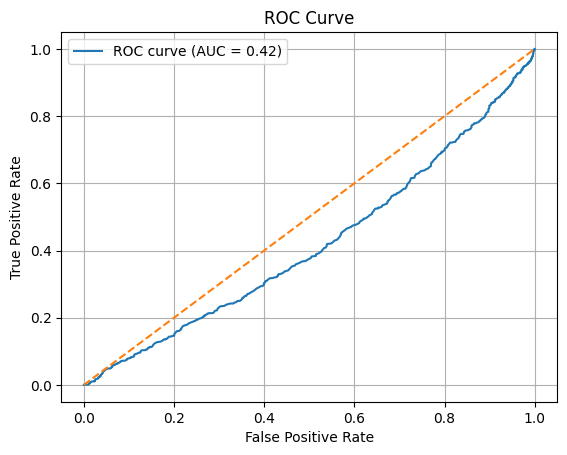

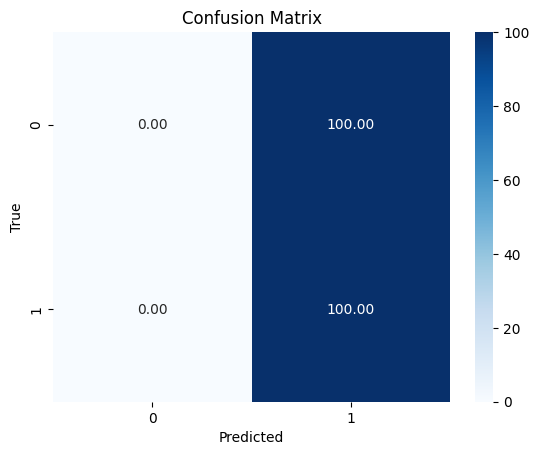

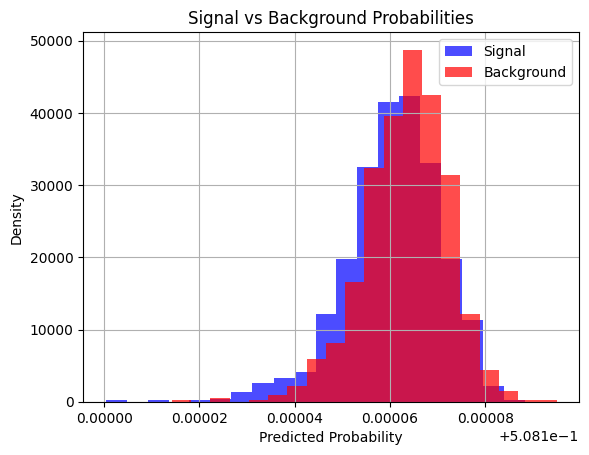

/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto
r.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

Precision: 0.6348, Recall: 0.4595, F1: 0.5331, ROC AUC: 0.6447

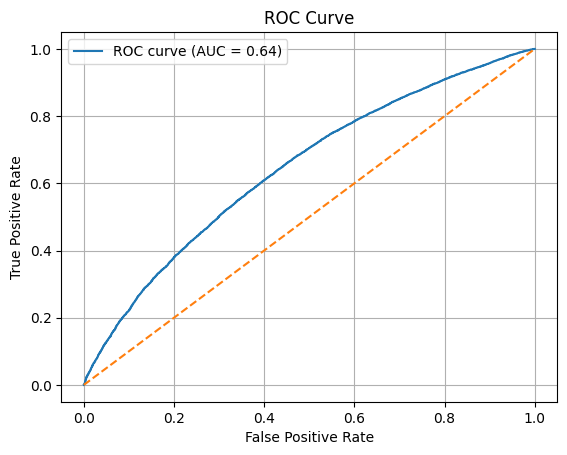

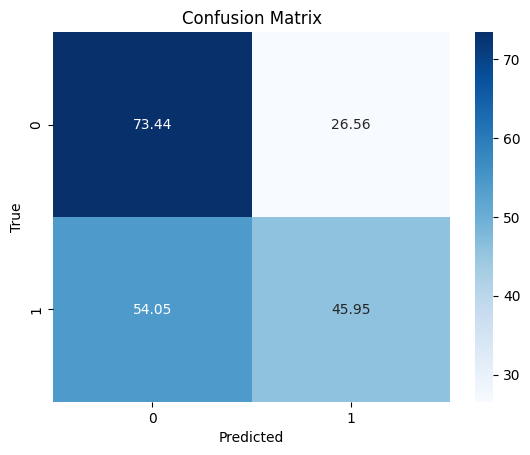

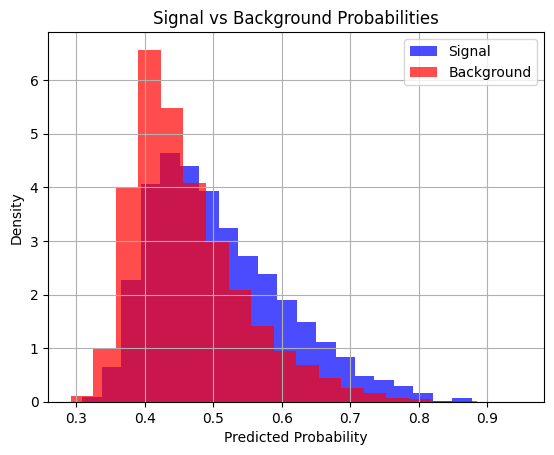

Precision: 0.6736, Recall: 0.3794, F1: 0.4854, ROC AUC: 0.6607

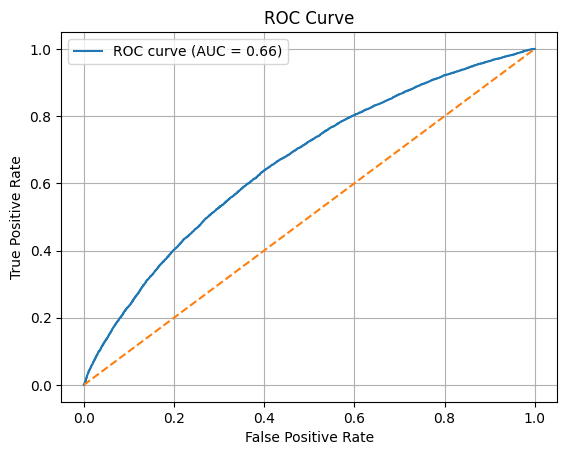

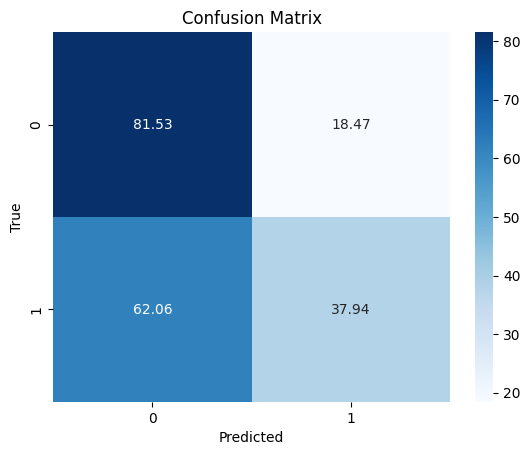

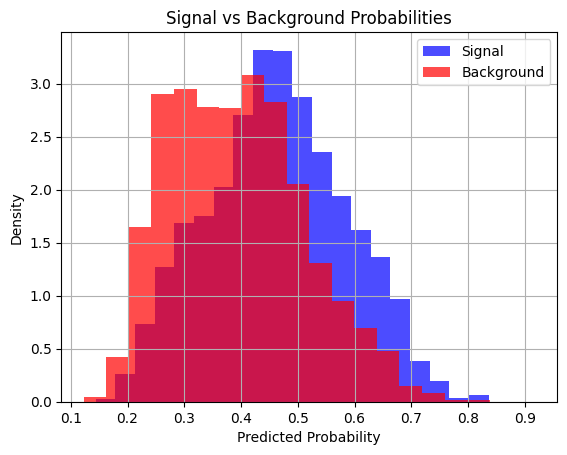

Precision: 0.6046, Recall: 0.6913, F1: 0.6451, ROC AUC: 0.6671

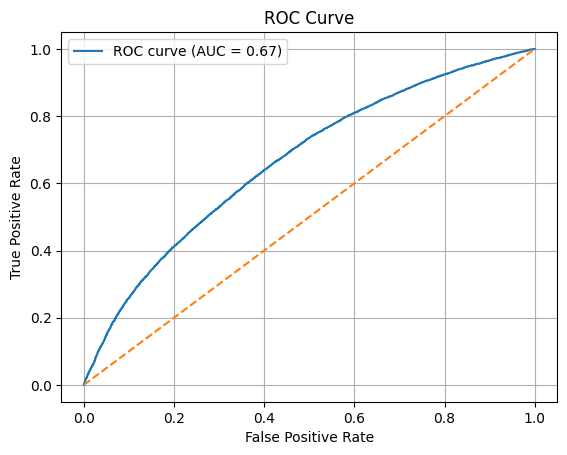

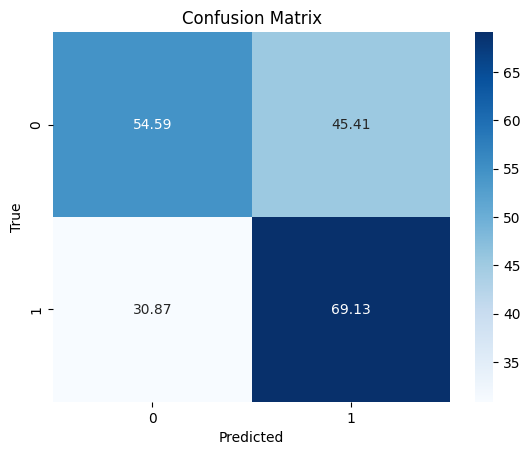

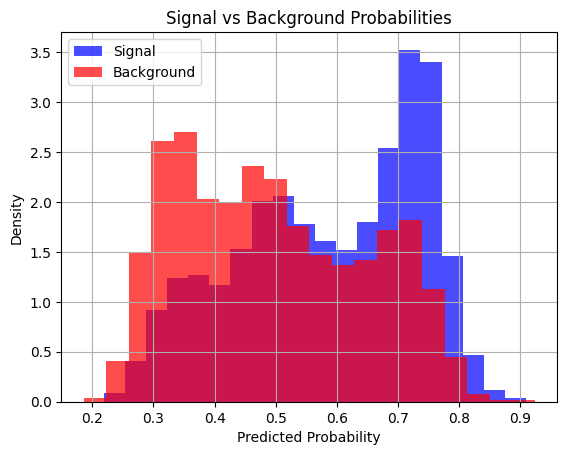

Precision: 0.6177, Recall: 0.6936, F1: 0.6535, ROC AUC: 0.6769

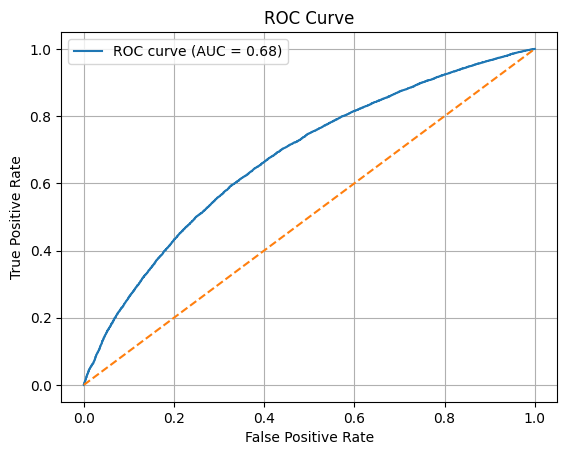

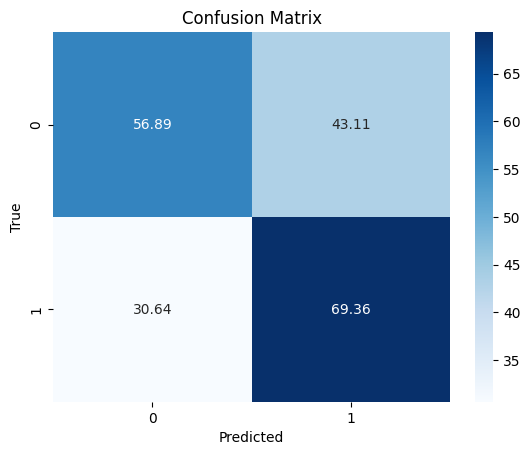

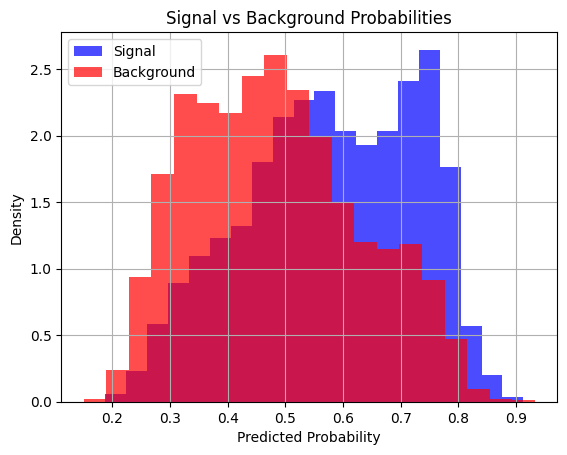

Precision: 0.6682, Recall: 0.5291, F1: 0.5906, ROC AUC: 0.6838

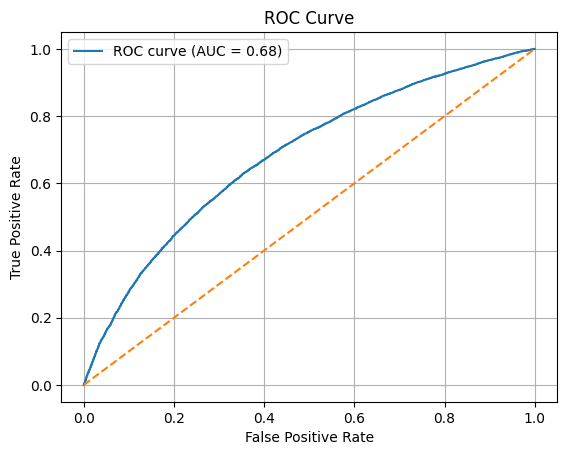

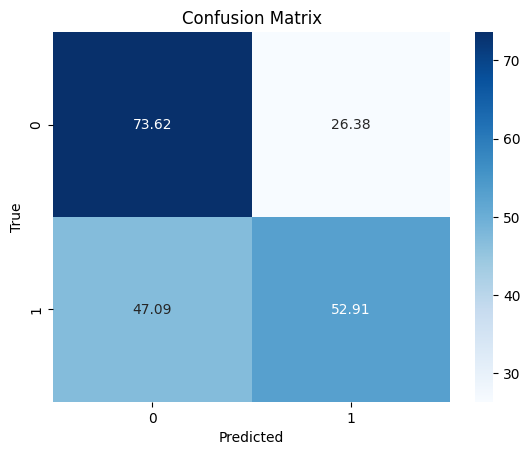

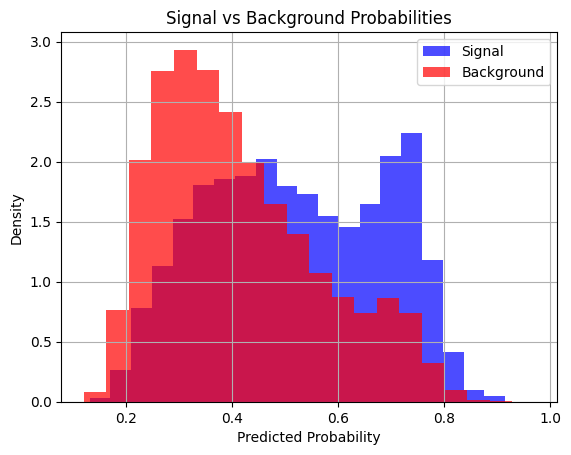

Precision: 0.6879, Recall: 0.5097, F1: 0.5856, ROC AUC: 0.6940

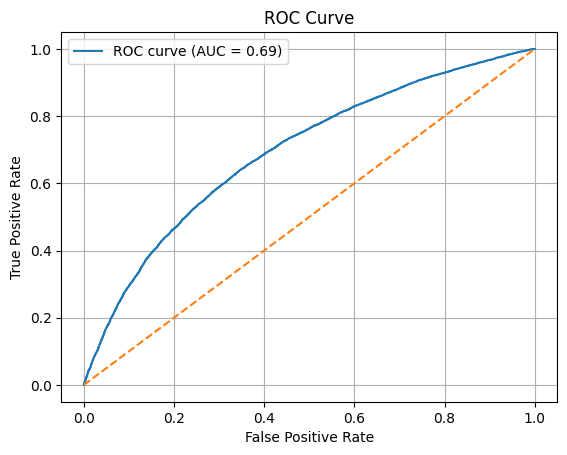

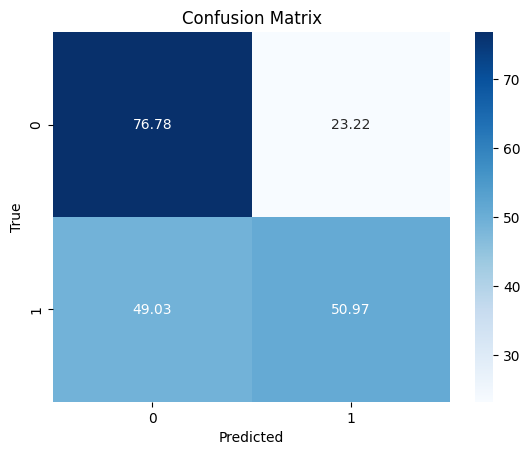

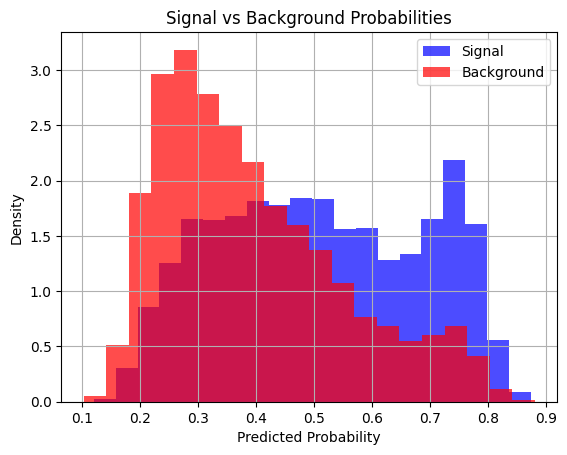

Precision: 0.6952, Recall: 0.5170, F1: 0.5930, ROC AUC: 0.7023

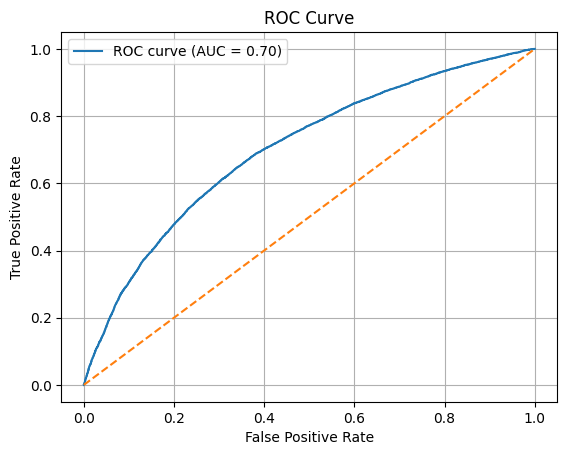

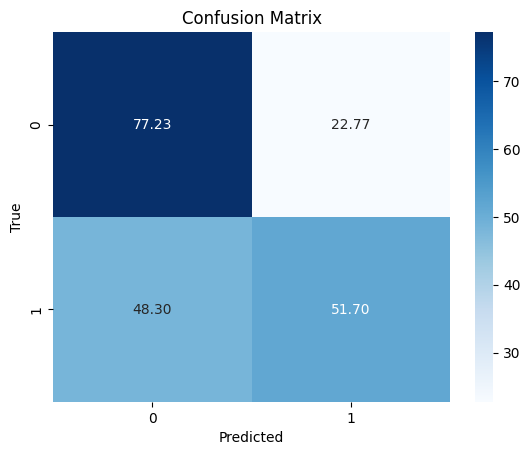

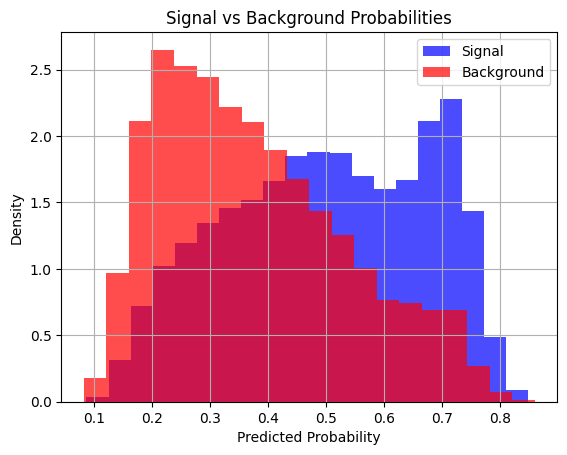

Precision: 0.6638, Recall: 0.6278, F1: 0.6453, ROC AUC: 0.7027

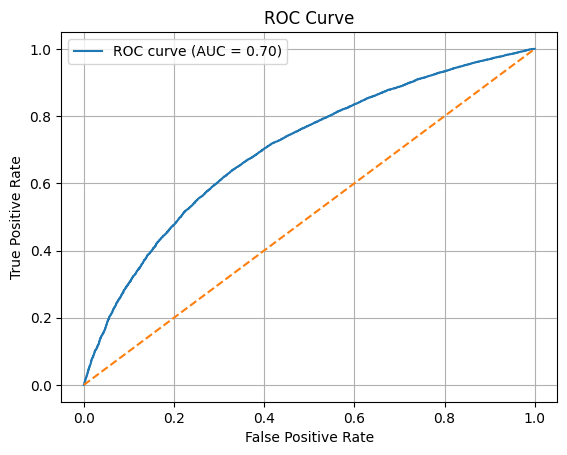

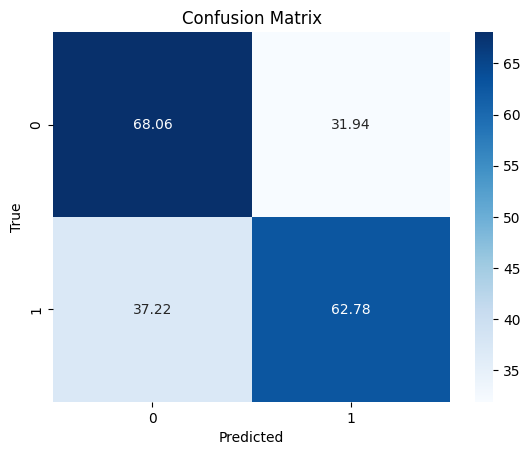

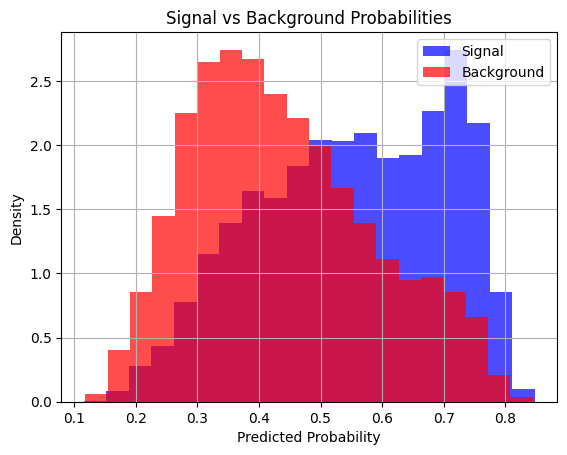

Precision: 0.6886, Recall: 0.5738, F1: 0.6260, ROC AUC: 0.7099

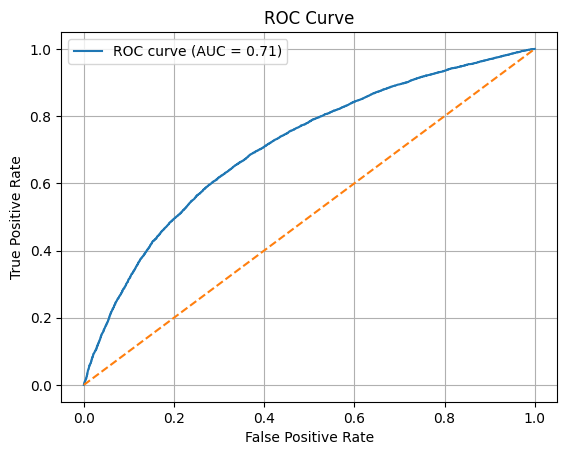

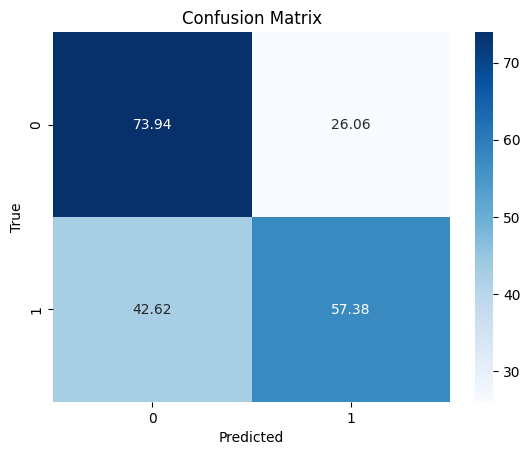

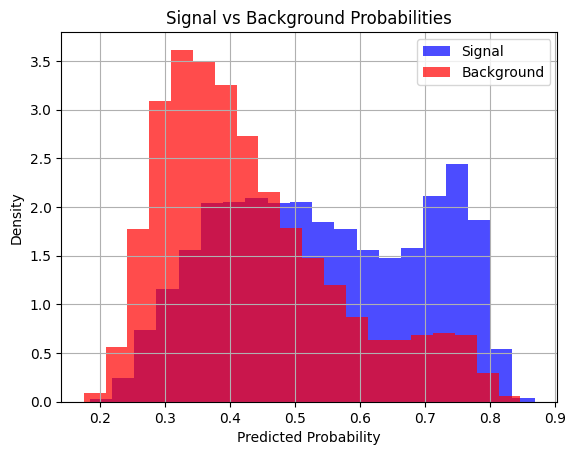

Precision: 0.7076, Recall: 0.5314, F1: 0.6070, ROC AUC: 0.7121

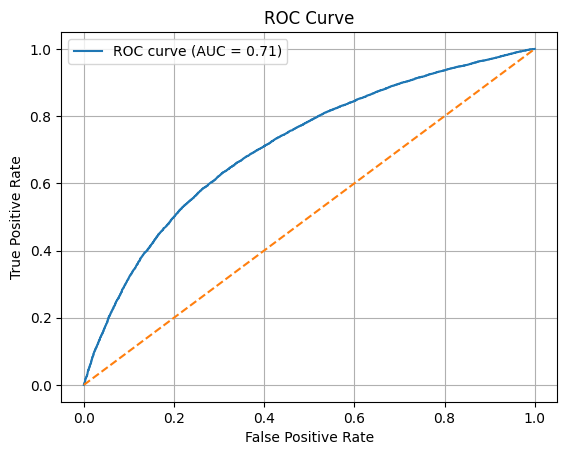

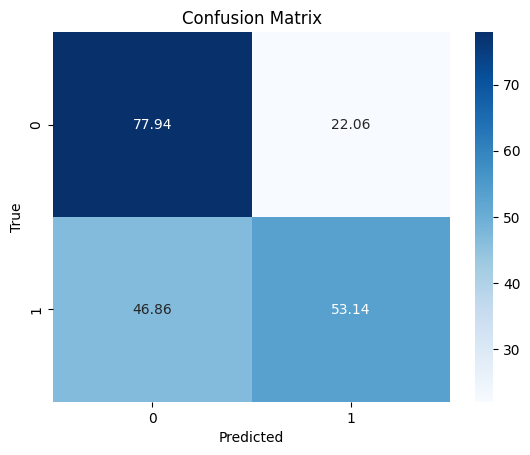

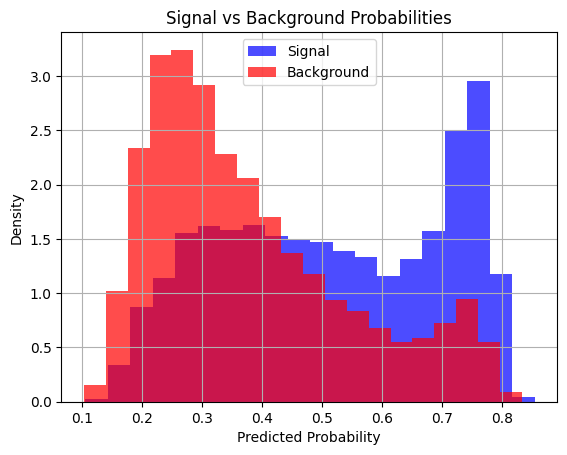

Precision: 0.6994, Recall: 0.5687, F1: 0.6273, ROC AUC: 0.7140

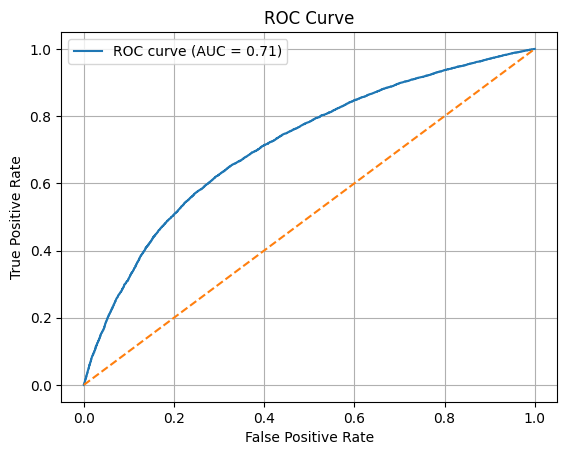

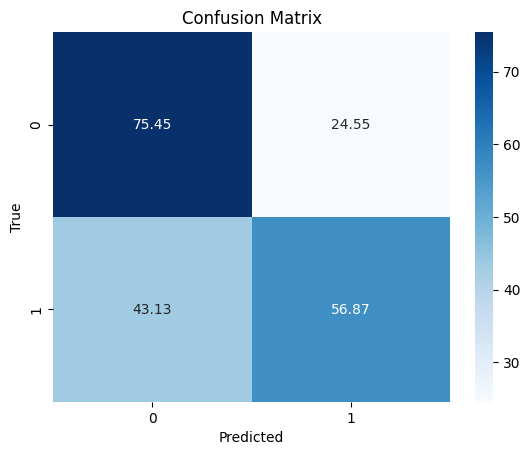

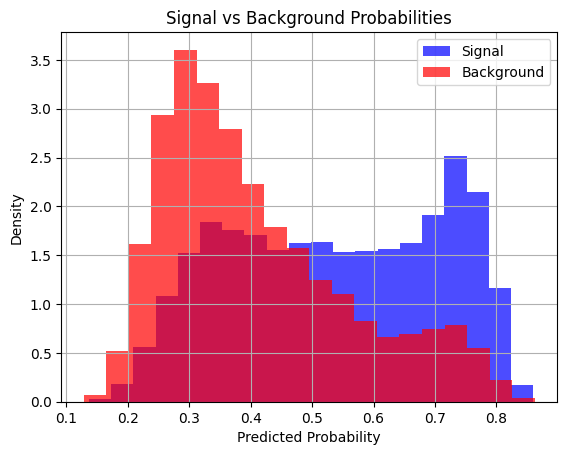

Precision: 0.7057, Recall: 0.5473, F1: 0.6165, ROC AUC: 0.7153

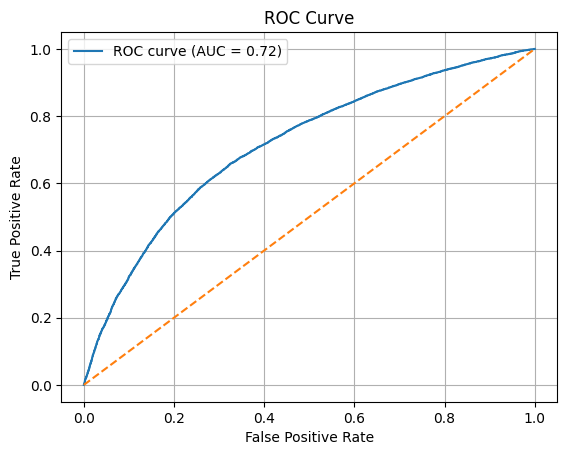

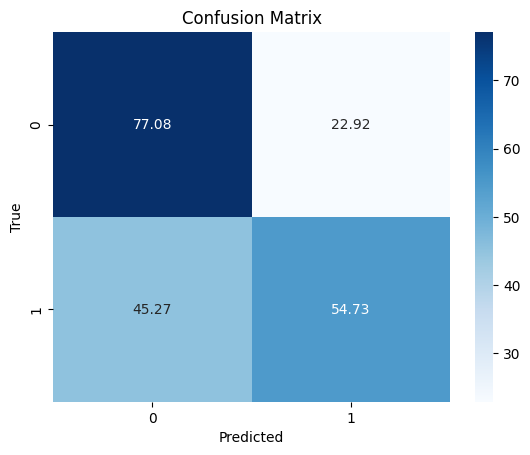

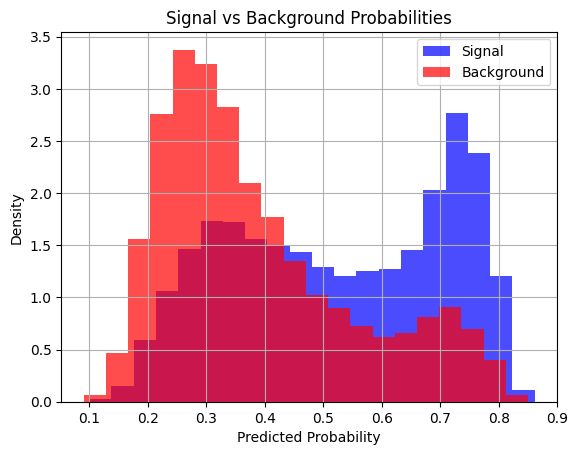

Precision: 0.6858, Recall: 0.6138, F1: 0.6479, ROC AUC: 0.7193

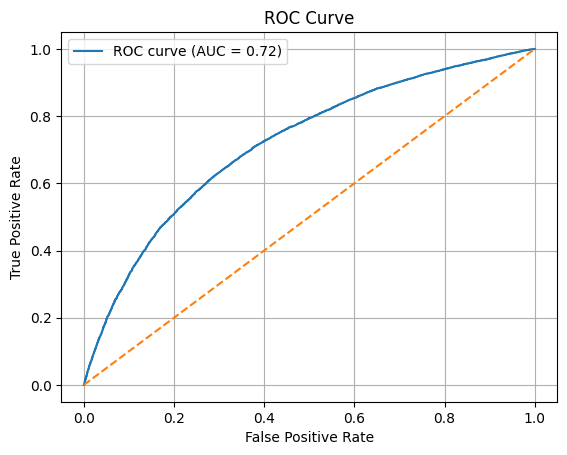

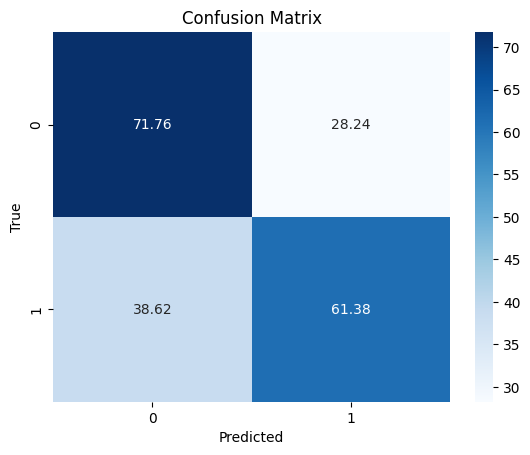

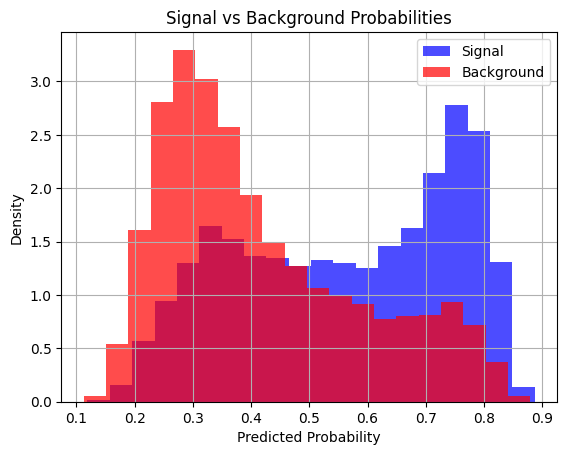

Precision: 0.5993, Recall: 0.8245, F1: 0.6941, ROC AUC: 0.7160

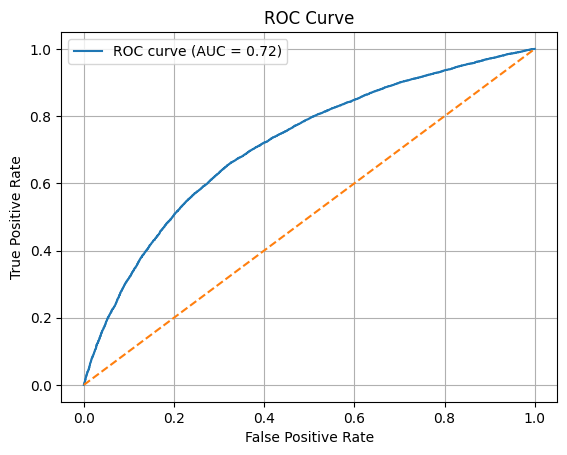

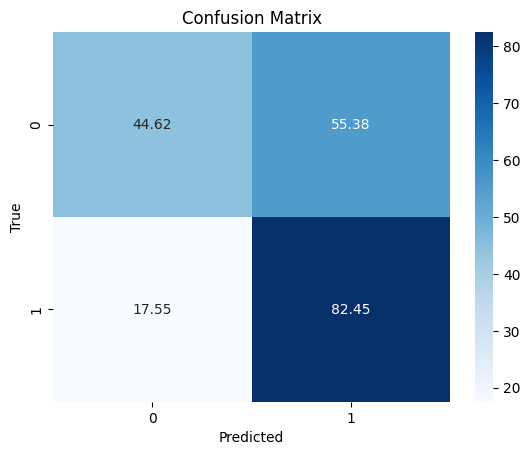

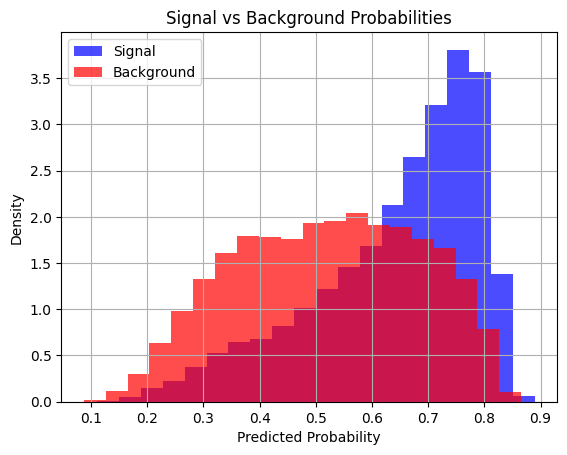

Precision: 0.6944, Recall: 0.6023, F1: 0.6451, ROC AUC: 0.7203

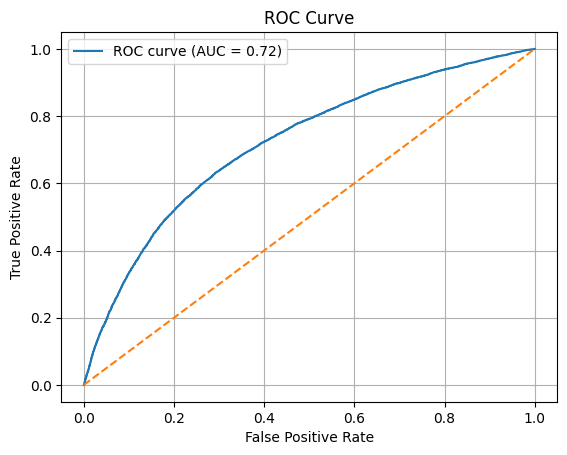

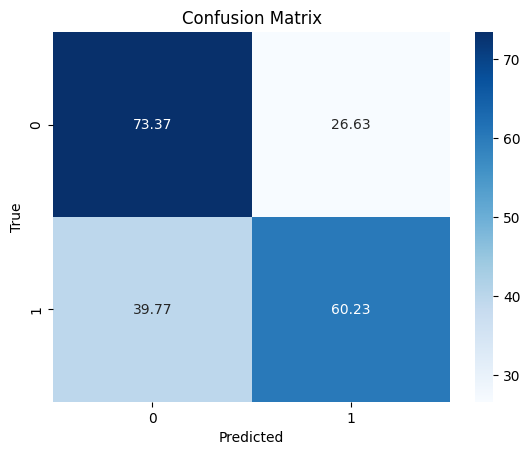

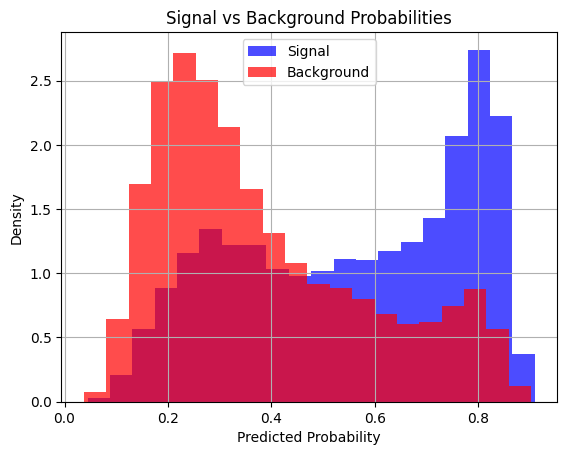

Precision: 0.6969, Recall: 0.5850, F1: 0.6361, ROC AUC: 0.7212

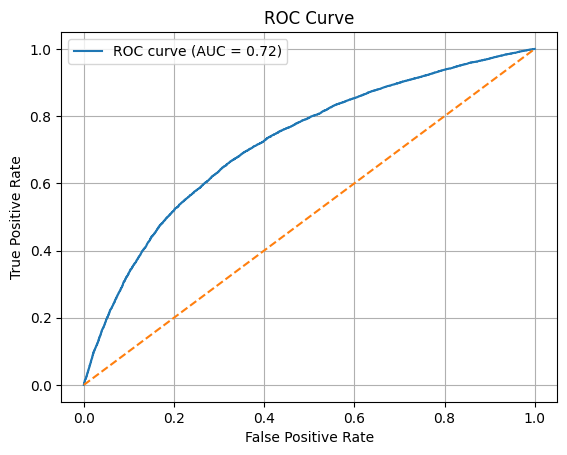

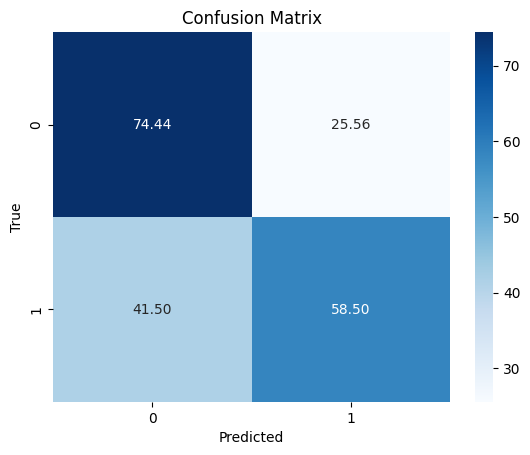

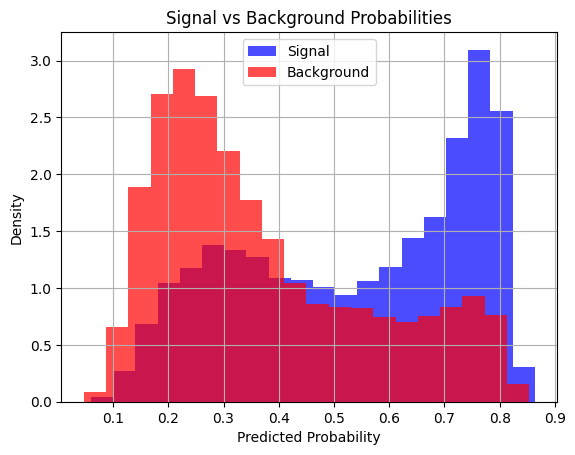

Precision: 0.7095, Recall: 0.5710, F1: 0.6328, ROC AUC: 0.7248

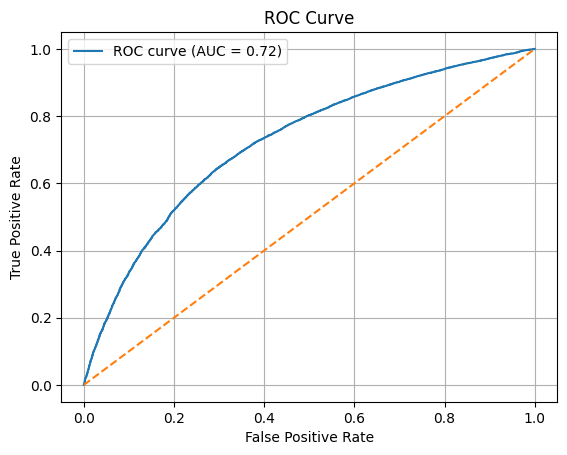

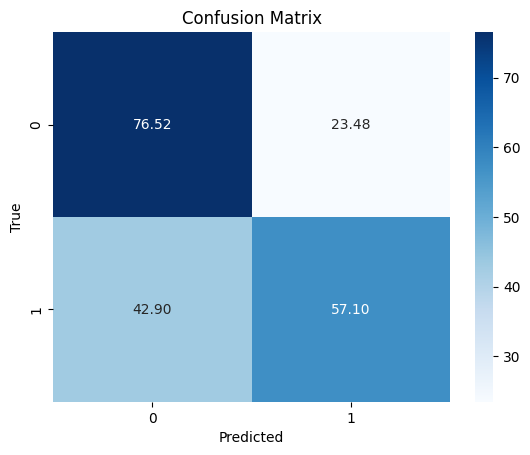

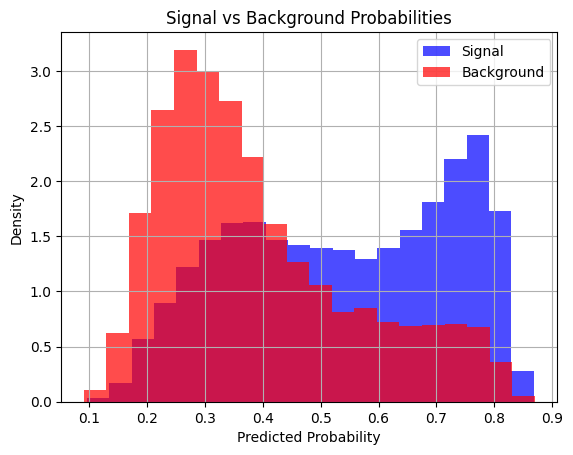

Precision: 0.6667, Recall: 0.6876, F1: 0.6769, ROC AUC: 0.7245

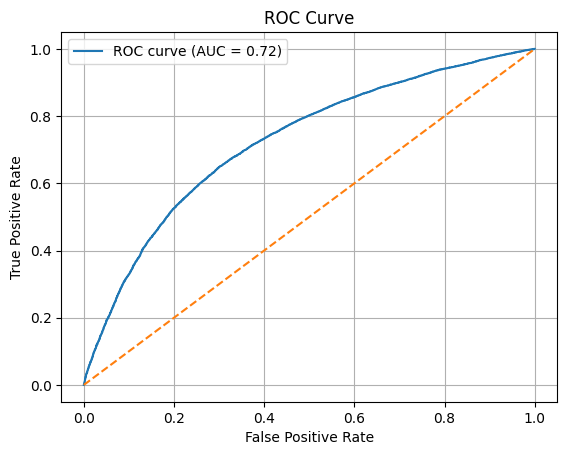

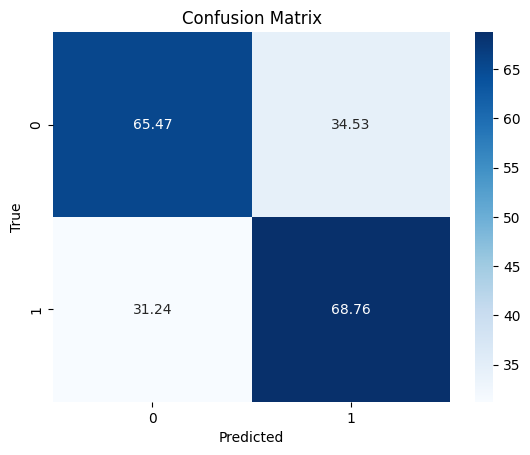

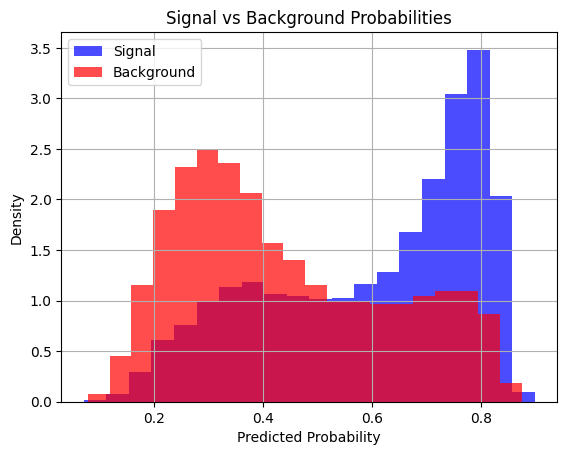

Precision: 0.6757, Recall: 0.6621, F1: 0.6689, ROC AUC: 0.7220

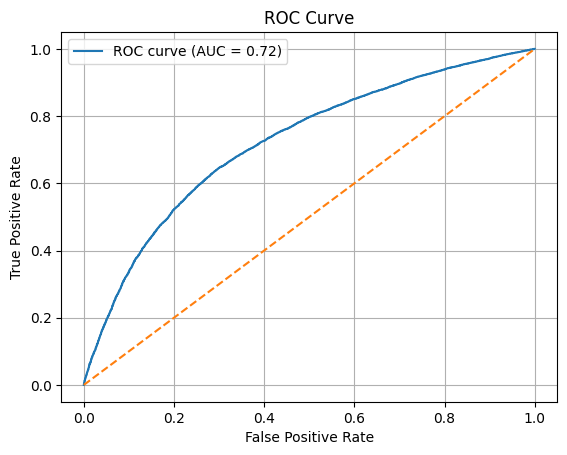

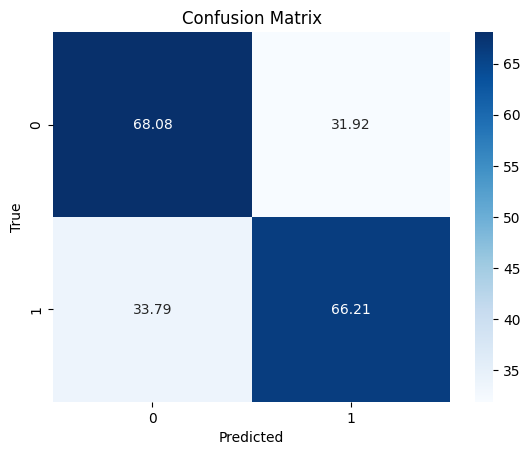

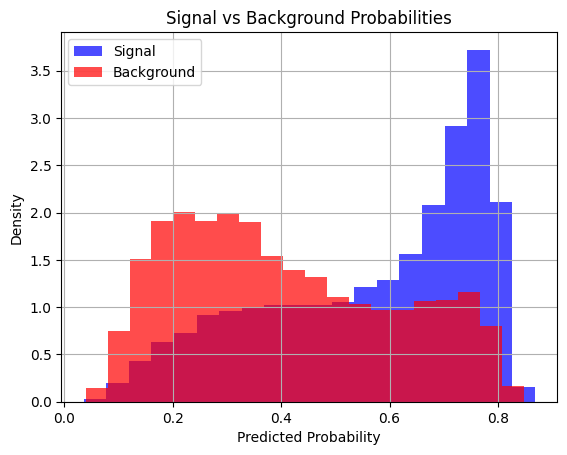

Precision: 0.7144, Recall: 0.5432, F1: 0.6172, ROC AUC: 0.7231

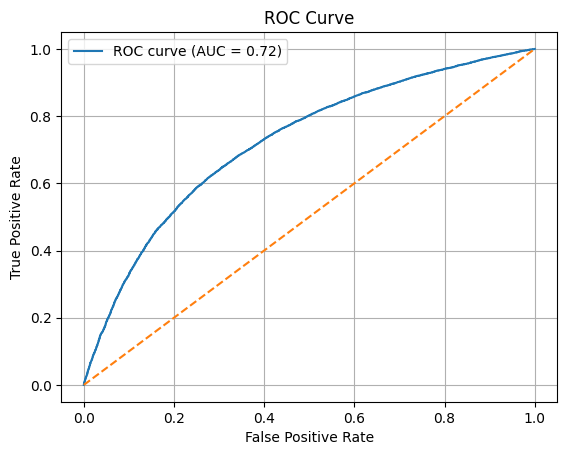

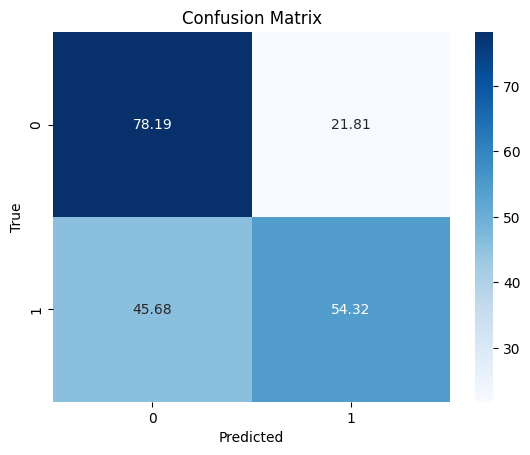

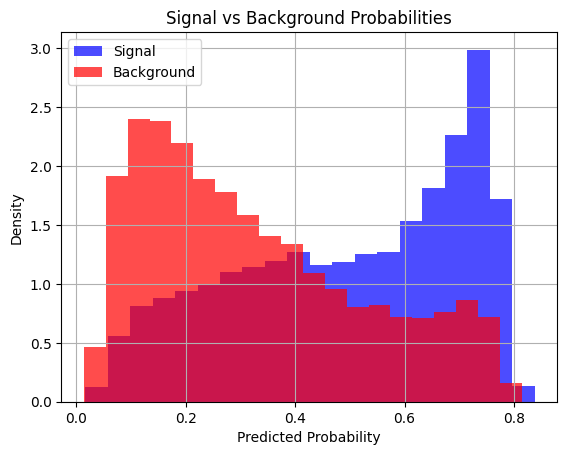

Precision: 0.7017, Recall: 0.5872, F1: 0.6394, ROC AUC: 0.7225

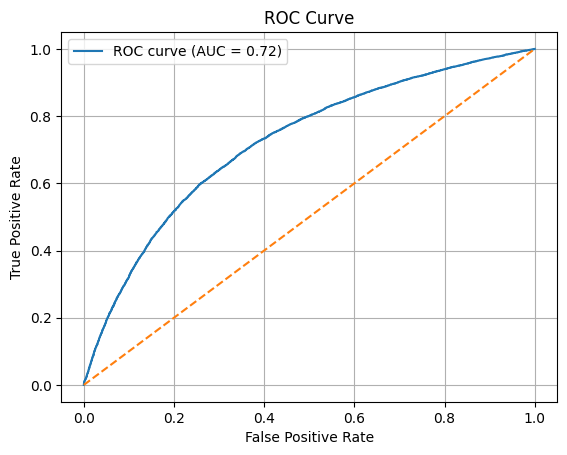

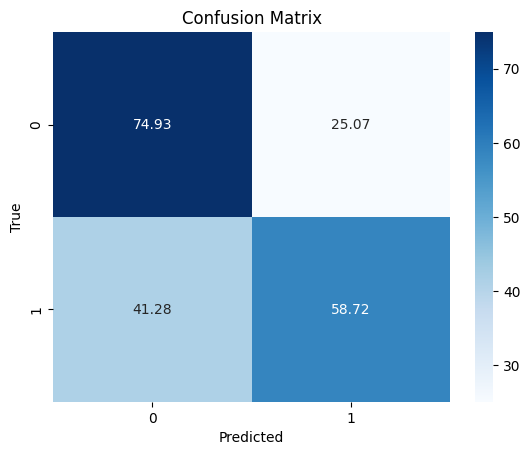

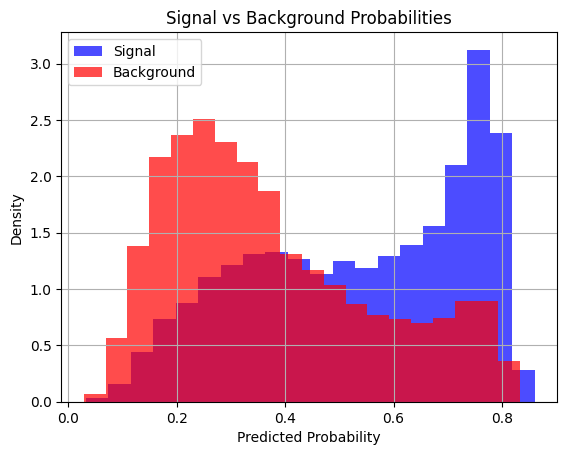

Precision: 0.6762, Recall: 0.6655, F1: 0.6708, ROC AUC: 0.7244

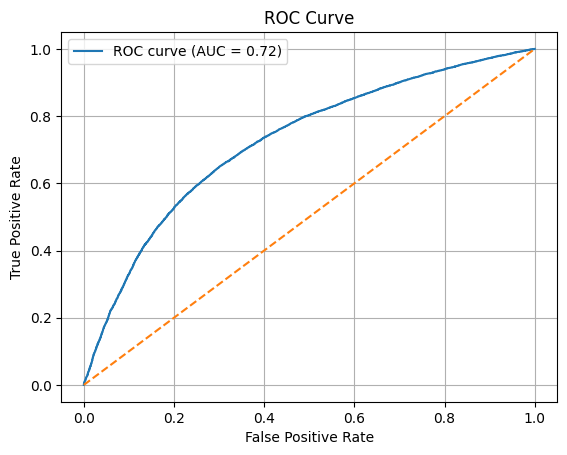

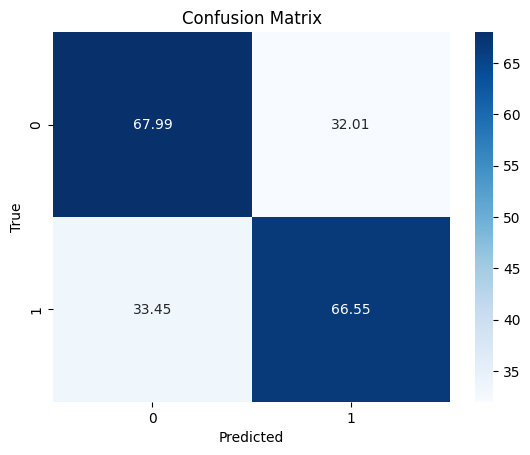

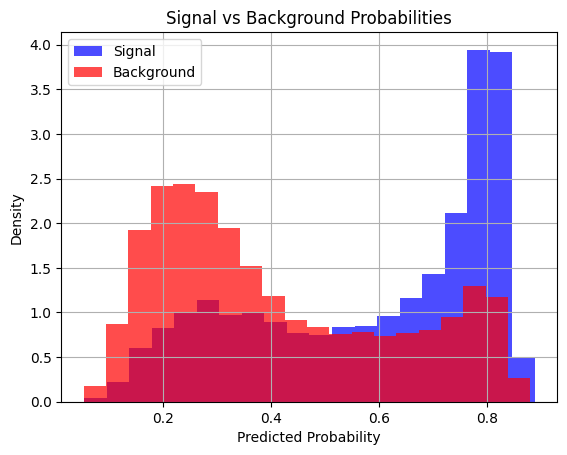

Precision: 0.7216, Recall: 0.5244, F1: 0.6074, ROC AUC: 0.7233

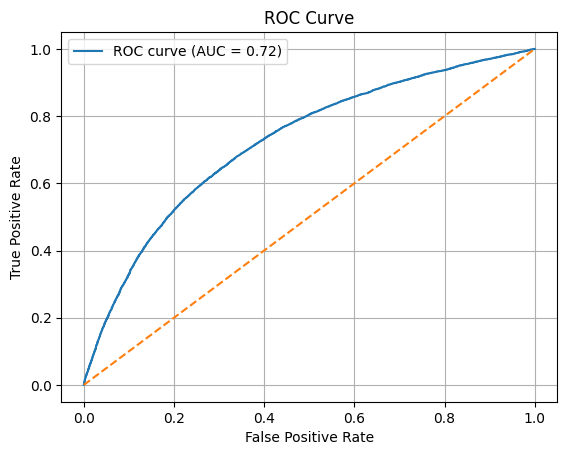

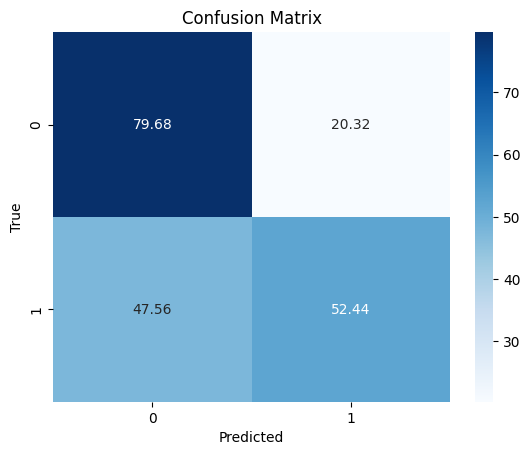

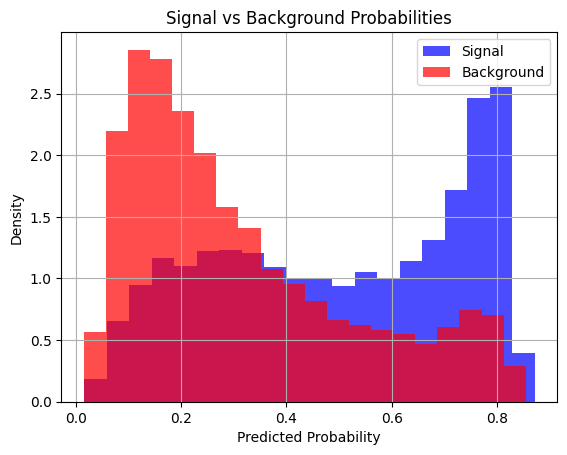

Precision: 0.6618, Recall: 0.6983, F1: 0.6796, ROC AUC: 0.7231

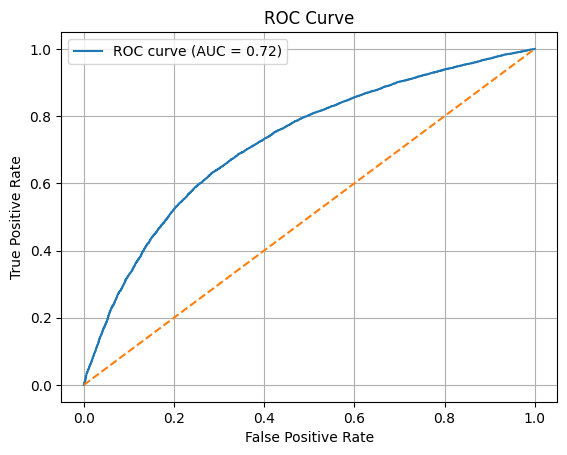

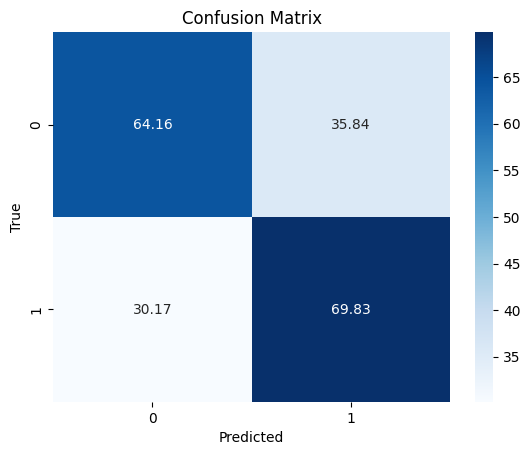

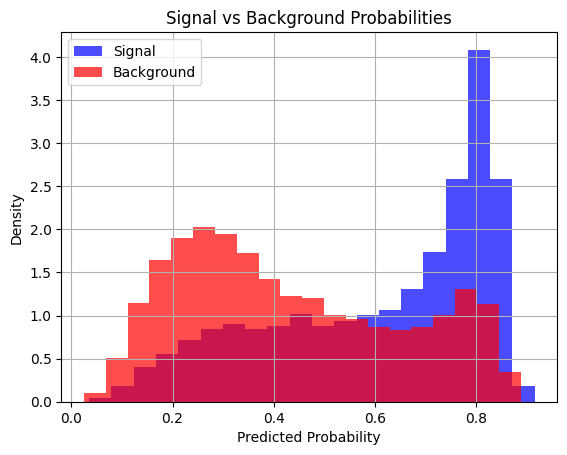

Precision: 0.6809, Recall: 0.6537, F1: 0.6670, ROC AUC: 0.7242

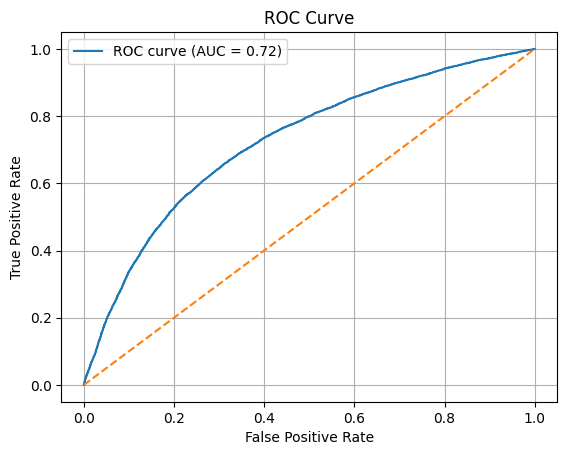

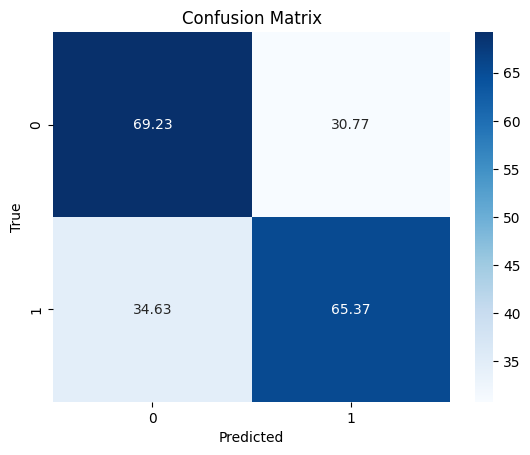

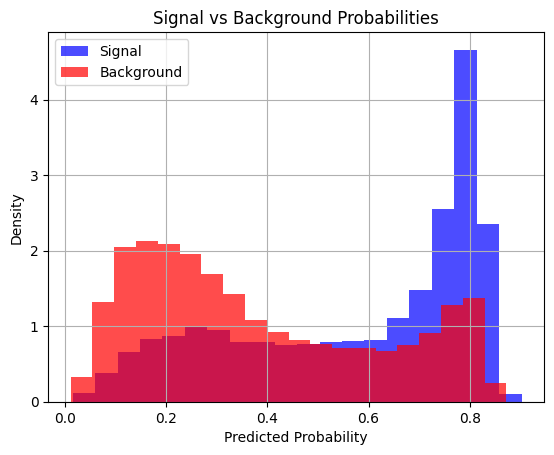

`Trainer.fit` stopped: `max_epochs=25` reached.


In [30]:

# Train the model
model = HyPERModel()
trainer = Trainer(max_epochs=25, accelerator='auto', logger=logger,callbacks=[checkpoint_cb],)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)



In [31]:
model = HyPERModel.load_from_checkpoint(
    "twz_results_feb16/hyper-best.ckpt"
)
model.eval()


RuntimeError: Error(s) in loading state_dict for HyPERModel:
	size mismatch for model.MPNNBlock.edge_model.edge_mlp.0.weight: copying a param with shape torch.Size([64, 29]) from checkpoint, the shape in current model is torch.Size([128, 29]).
	size mismatch for model.MPNNBlock.edge_model.edge_mlp.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.MPNNBlock.edge_model.edge_mlp.3.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for model.MPNNBlock.edge_model.edge_mlp.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.MPNNBlock.edge_model.edge_mlp.6.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for model.MPNNBlock.node_model.node_mlp_1.0.weight: copying a param with shape torch.Size([64, 27]) from checkpoint, the shape in current model is torch.Size([128, 27]).
	size mismatch for model.MPNNBlock.node_model.node_mlp_1.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.MPNNBlock.node_model.node_mlp_1.3.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for model.MPNNBlock.node_model.node_mlp_1.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.MPNNBlock.node_model.node_mlp_1.6.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for model.MPNNBlock.node_model.node_mlp_1.6.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.MPNNBlock.node_model.node_mlp_2.0.weight: copying a param with shape torch.Size([64, 143]) from checkpoint, the shape in current model is torch.Size([128, 271]).
	size mismatch for model.MPNNBlock.node_model.node_mlp_2.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.MPNNBlock.node_model.node_mlp_2.3.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for model.MPNNBlock.node_model.node_mlp_2.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.MPNNBlock.node_model.node_mlp_2.6.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for model.MPNNBlock.node_model.node_mlp_2.6.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.MPNNBlock.global_model.global_mlp.0.weight: copying a param with shape torch.Size([64, 130]) from checkpoint, the shape in current model is torch.Size([128, 258]).
	size mismatch for model.MPNNBlock.global_model.global_mlp.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.MPNNBlock.global_model.global_mlp.3.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for model.MPNNBlock.global_model.global_mlp.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.MPNNBlock.global_model.global_mlp.6.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for model.MPNNBlock.global_model.global_mlp.6.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for hyper.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for hyper.mlp_x.0.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for hyper.mlp_x.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for hyper.mlp_x.3.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for hyper.mlp_x.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for hyper.mlp_x.6.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for hyper.mlp_x.6.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for hyper.x_hat.0.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for hyper.x_hat.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for hyper.x_hat.3.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for hyper.x_hat.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for hyper.x_hat.6.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).

In [ ]:
import joblib

y_true, y_pred = joblib.load(
    "twz_results_feb16/hyper_model_output.pkl"
)


In [ ]:
# from pytorch_lightning import LightningModule

# model = HyPERModel.load_from_checkpoint("results/hyper_model.ckpt")

# model.freeze()


In [ ]:
# import torch
# import numpy as np

# all_preds = []
# all_labels = []

# device = model.device

# with torch.no_grad():
#     for batch in test_loader:
#         batch = batch.to(device)

#         x_hat, batch_hyper, _ = model(batch)

#         # event-level aggregation (same as training)
#         x_event_pred = torch.zeros_like(batch.x_t.float())
#         for i in range(len(batch.x_t)):
#             x_event_pred[i] = x_hat[batch_hyper == i].mean()

#         all_preds.append(x_event_pred.cpu())
#         all_labels.append(batch.x_t.cpu())

# y_pred = torch.cat(all_preds).numpy()
# y_true = torch.cat(all_labels).numpy()


In [ ]:
# from sklearn.metrics import (
#     roc_auc_score, accuracy_score, precision_score,
#     recall_score, f1_score, confusion_matrix
# )

# y_pred_class = (y_pred > 0.5).astype(int)

# roc  = roc_auc_score(y_true, y_pred)
# acc  = accuracy_score(y_true, y_pred_class)
# prec = precision_score(y_true, y_pred_class)
# rec  = recall_score(y_true, y_pred_class)
# f1   = f1_score(y_true, y_pred_class)

# print(f"""
# ROC AUC  : {roc:.4f}
# Accuracy : {acc:.4f}
# Precision: {prec:.4f}
# Recall   : {rec:.4f}
# F1-score : {f1:.4f}
# """)


In [ ]:
# root_file = "/home/sandeep/Desktop/sm_ltth_k1_1K2_0.root"

# data_list = load_data_hyper_format(root_file, label=0)  

In [ ]:
# from torch_geometric.loader import DataLoader

# infer_loader = DataLoader(
#     data_list,
#     batch_size=128,
#     shuffle=False
# )


In [ ]:
# import numpy as np

# all_event_scores = []

# with torch.no_grad():
#     for batch in infer_loader:
#         batch = batch.to(device)

#         x_hat, batch_hyper, _ = model(batch)

#         # event-level aggregation
#         x_event_pred = torch.zeros(len(batch.x_t), device=device)

#         for i in range(len(batch.x_t)):
#             x_event_pred[i] = x_hat[batch_hyper == i].mean()

#         all_event_scores.append(x_event_pred.cpu())


In [ ]:
# event_scores = torch.cat(all_event_scores).numpy()


In [ ]:
# threshold = 0.5
# event_classes = (event_scores > threshold).astype(int)

# n_signal = event_classes.sum()
# n_total  = len(event_classes)
# n_bkg    = n_total - n_signal


In [ ]:
# print(f"Total events     : {n_total}")
# print(f"Classified signal: {n_signal}")
# print(f"Classified bkg   : {n_bkg}")
# print(f"Signal fraction  : {n_signal / n_total:.3f}")


In [ ]:
# import joblib

# joblib.dump(
#     {
#         "event_scores": event_scores,
#         "event_classes": event_classes
#     },
#     "twz_results/inference_results.pkl"
# )


In [ ]:
# import matplotlib.pyplot as plt

# plt.hist(event_scores, bins=40, alpha=0.8)
# plt.axvline(0.5, color="red", linestyle="--", label="threshold")
# plt.xlabel("Predicted signal probability")
# plt.ylabel("Events")
# plt.legend()
# plt.grid()
# plt.show()
